In [12]:
import numpy as np
from shapely.geometry import Polygon, shape, Point
import json
import gdal
from skimage import io

In [13]:
%matplotlib inline

In [14]:
img = gdal.Open("3band_AOI_1_RIO_img5151.tif")
geotrans = img.GetGeoTransform()
#s fetch the affine transformation coefficients
# fetch the coefficients for transforming between pixel/line(P,L) raster space, and
# projection coordinates (Xp,Yp) space
# In a north up image,
# padTransform[0]: top left x
# padTransform[1]:pixel width
# padTransform[2]: 0
# padTransform[3]: top left y
# padTransform[4]: 0
# padTransform[5]:pixel height (negative value)
# the upper left corner of the upper left pixel is at position (padTranform[0],padTransform[3])

In [15]:
# compute the distance per pixel represents
unit = (np.abs(geotrans[1]) + np.abs(geotrans[5]))/2

In [16]:
def coord2real(GeoTrans, i, j):
    # this function is to transform the coordinate (i,j) in the tif to the real world
    ulx = GeoTrans[0]
    uly = GeoTrans[3]
    width = GeoTrans[1]
    height = GeoTrans[5]
    return (ulx + 1.0*i*width, uly + 1.0*j*height)

C:\Users\huijian\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


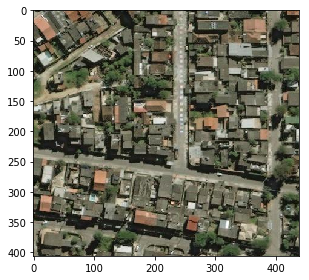

In [17]:
new_img = io.imread("3band_AOI_1_RIO_img5151.tif")
io.imshow(new_img)

In [18]:
with open("Geo_AOI_1_RIO_img5151.geojson") as file:
    js = json.load(file)
    distance = np.zeros((img.RasterXSize,img.RasterYSize),dtype=np.float32)
    for i in range(img.RasterXSize):
        for j in range(img.RasterYSize):
            point = Point(coord2real(geotrans,i,j)) 
            pd = - 100000.0 # point distance
            for feature in js["features"]: # js["features"]->list
                polygon = shape(feature["geometry"])
                newpd = point.distance(polygon.boundary)
                # no matter the point is contained by the polygon or not,
                # the distance will be a non-negative value.
                if False==polygon.contains(point):
                    newpd = -1.0 * newpd
                if newpd > pd:
                    pd = newpd
            distance[i,j] = pd

C:\Users\huijian\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


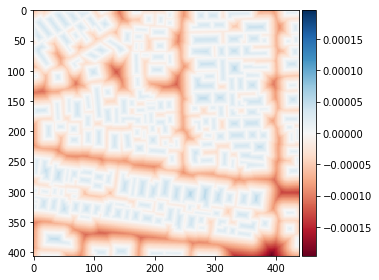

In [19]:
# the gdal x-y is different from what we are familar with
distance = distance.transpose(1,0)
io.imshow(distance)

C:\Users\huijian\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\huijian\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


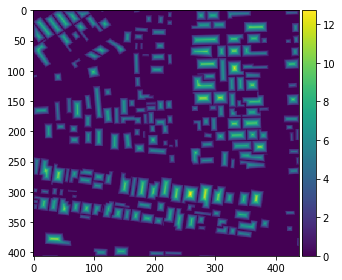

In [20]:
# clean all the negative values
distance[distance<0]=0
distance = distance/unit
io.imshow(distance)

C:\Users\huijian\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


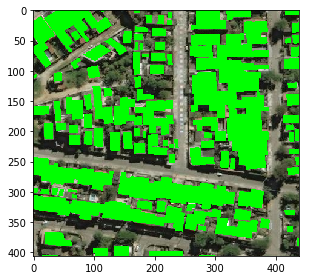

In [21]:
mask = (distance>0)
new_img[mask,:]=0
new_img[mask,1]=255
io.imshow(new_img)